In [32]:
import pymongo
from pymongo import MongoClient
from google.cloud import bigquery
from bson import ObjectId
from google.cloud import bigquery_storage_v1
from functools import partialmethod

import datetime as dt
import pandas as pd
import numpy as np
import requests
import json

from sklearn import preprocessing
import matplotlib.pyplot as plt

%matplotlib inline  

In [5]:
# Забираем все картинки, бьем их по категориям, смотрим на корреляцию между количеством шейпов и коэффициентом 
# закрашивания картинки 


# Забираем весь фид со ссылками на векторные картинки
# 'https://cdnmains3.color.auragames.co/feeds/5ef1a73a73613e00112db419' #"DAILY PRODUCTION" 
# 'https://cdnmains3.color.auragames.co/feeds/5ef4559473613e00112db462' #"BONUS PRODUCTION"

urls = ['https://cdnmains3.color.auragames.co/feeds/5e4e90dee8a3eb6eaaa117f7',
       'https://cdnmains3.color.auragames.co/feeds/5ef1a73a73613e00112db419',
       'https://cdnmains3.color.auragames.co/feeds/5ef4559473613e00112db462'] 
all_feed = pd.DataFrame()

for i in urls:
    url = requests.get(i)
    all_feed_ = url.json()
    all_feed_ = pd.DataFrame(all_feed_['items']) 
    all_feed_ = all_feed_[['id', 'svg', 'type', 'tags', 'createTimestamp']]
    all_feed_['feed_id'] = i
    all_feed = pd.concat([all_feed, all_feed_], ignore_index=True, sort=False)    

all_feed.createTimestamp.replace('Mon Mar 01 2021 13:56:16 GMT+0000 (Coordinated Universal Time)', 
                                   '2021-03-01T13:56:16.000Z', inplace=True)
all_feed.createTimestamp.replace('Tue Mar 02 2021 11:47:09 GMT+0000 (Coordinated Universal Time)', 
                                   '2021-03-02T11:47:09.000Z', inplace=True)
all_feed['createTimestamp'] = pd.to_datetime(all_feed['createTimestamp']).dt.tz_localize(None)

all_feed = all_feed.explode('tags')
all_feed['tags'] = np.where(all_feed.feed_id=='https://cdnmains3.color.auragames.co/feeds/5ef1a73a73613e00112db419', 
                            'daily', all_feed.tags)


In [8]:
client = bigquery.Client.from_service_account_json('./creds.json')
bigquery_storage_v1.client.BigQueryReadClient.read_rows = partialmethod(bigquery_storage_v1.client.BigQueryReadClient.read_rows, timeout=3600*2) 
bq_storage_client = bigquery_storage_v1.BigQueryReadClient.from_service_account_json('./creds.json')
project_id = 'goingtoclouds'

sql = '''
select b.picture_id, pinished_pics, started_pics, pinished_pics/started_pics as finish_coef
from (
    SELECT picture_id, count(distinct customer_user_id) as pinished_pics 
    FROM `goingtoclouds.aggregated_data.picture_finish`
    where country !='Belarus' and customer_user_id not in (0, 31)
    group by picture_id) as a
right JOIN (
    SELECT picture_id, count(distinct customer_user_id) as started_pics 
    FROM `goingtoclouds.aggregated_data.picture_start`
    where country !='Belarus' and customer_user_id not in (0, 31)
    group by picture_id
) as b
on a.picture_id=b.picture_id
'''
all_pics = client.query(sql, project=project_id).to_dataframe()
all_pics = all_pics[all_pics.picture_id.isin(all_feed.id.unique().tolist())]

In [11]:
all_feed = all_feed.merge(all_pics, how='left', left_on='id', right_on='picture_id')
all_feed = all_feed[~all_feed.picture_id.isna()]

# Извлекаем ТОЛЬКО старые картинки
new_pectures_time = pd.to_datetime(dt.datetime.utcnow() - dt.timedelta(hours=48))
all_feed = all_feed[all_feed['createTimestamp'] < new_pectures_time]

In [15]:
# Забираем количество шейпов и цветов из монго
login = 'user1'
password = 'cPvclw4i57sAFKFk'
db_name = 'hc-prod'

client = MongoClient('mongodb+srv://{}:{}@hc-prod-db.qzq5d.mongodb.net/@hc-prod-db.qzq5d.mongodb.net/{}?retryWrites=true&w=majority'.format(login, password, db_name))
db = client.hc_prod

json_data_image = db['Image'].find({})

img_arr = all_feed.id.tolist()
images = pd.DataFrame()

tesselatorCoreInfo_arr = []
for document in json_data_image:
    id = document['_id'].__str__()        
    if id in img_arr:            
        if 'totalshapesCount' in document['tesselatorCoreInfo']:
            tesselatorCoreInfo = document['tesselatorCoreInfo']
            totalshapesCount = tesselatorCoreInfo['totalshapesCount']
            colorsCount = tesselatorCoreInfo['colorsCount']
            tesselatorCoreInfo_arr.append({'id': id, 'totalshapesCount': totalshapesCount, 'colorsCount': colorsCount}) 
images = pd.json_normalize(tesselatorCoreInfo_arr, max_level=0)   

In [327]:
# Считаем корреляции и строим графички
correlations = all_feed[all_feed.type=='published'][['id', 'tags', "pinished_pics", 'started_pics', 
                                                     'finish_coef']].merge(images, how='left', on='id')
correlations = correlations[~correlations.totalshapesCount.isna()]
correlations = correlations[~correlations.tags.isna()]

spearman_corr = correlations.groupby('tags')[['finish_coef',"totalshapesCount"]].corr(method='spearman').reset_index()

In [328]:
spearman_corr[spearman_corr.level_1=='totalshapesCount'][['tags', "finish_coef"]].sort_values('finish_coef')

tags  finish_coef
31         mandalas    -0.828655
41           simple    -0.723321
13            daily    -0.679302
3               art    -0.635877
21          flowers    -0.606185
43           travel    -0.549107
19          fashion    -0.548574
9         buildings    -0.517867
33           nature    -0.507506
11      butterflies    -0.499525
23             food    -0.479872
5             birds    -0.468753
17          fantasy    -0.468061
25         holidays    -0.446838
1           animals    -0.440378
37           people    -0.433573
35            other    -0.421225
15  editors' choice    -0.419559
29         interior    -0.418848
27       horoscopes    -0.353913
7             blend    -0.325669
39              sea    -0.280375
45         vehicles    -0.270155

In [371]:
correlations['quantile'] = correlations.groupby(['tags'])['totalshapesCount'].transform(lambda x: pd.qcut(x, 5, labels=False))
correlations
# correlations.groupby('tags')['totalshapesCount'].quantile([.25, .5, .75, 1]).reset_index().head(30)
# correlations.groupby('tags').qcut(['totalshapesCount'], 2, labels=False)
# pd.qcut(correlations['totalshapesCount'], 4, labels=False)



id         tags  pinished_pics  started_pics  \
0     6050a4d4e459440018c8c4e9      animals         3293.0        3898.0   
1     6050a4a9e459440018c8c4e7      fantasy         3036.0        3711.0   
2     6050a4a9e459440018c8c4e7       people         3036.0        3711.0   
3     6050a326e459440018c8c4e4       people         3530.0        4101.0   
4     6051fc57cb605d0018e8d300     mandalas         4199.0        4721.0   
...                        ...          ...            ...           ...   
4487  5f0321d394b6760011a3f3a3       people          107.0         121.0   
4488  5efc7051ec223c00118ec3e4       travel          823.0         936.0   
4489  5efc7051ec223c00118ec3e4        birds          823.0         936.0   
4490  5efb4aa82d6ef900112b3144  butterflies          167.0         187.0   
4491  5ef4548473613e00112db461      animals          133.0         147.0   

      finish_coef  totalshapesCount  colorsCount  quantile  
0        0.844792             281.0         54.0         0  
1        0.818108             481.0         78.0         1  
2        0.818108             481.0         78.0         1  
3        0.860766             354.0         59.0         0  
4        0.889430             550.0         24.0         1  
...           ...               ...          ...       ...  
4487     0.884298             654.0         60.0         2  
4488     0.879274             609.0         52.0         1  
4489     0.879274             609.0         52.0         2  
4490     0.893048             475.0         41.0         0  
4491     0.904762             503.0         57.0         2  

[4490 rows x 8 columns]

In [363]:
corr_q = correlations.groupby(['tags', 'quantile'])['finish_coef'].mean().reset_index()
corr_q = corr_q.pivot(index='tags', columns='quantile', values='finish_coef') 
corr_q.to_csv('corr_q.csv')

In [373]:
pic_num = correlations.groupby(['tags', "quantile"]).pinished_pics.sum().reset_index()
pic_num.pivot(index='tags', columns='quantile', values='pinished_pics').reset_index() 

quantile             tags         0         1         2         3         4
0                 animals  484608.0  418119.0  508757.0  451199.0  436475.0
1                     art   77800.0   73570.0   90287.0   77876.0  107081.0
2                   birds  211933.0  228810.0  213910.0  215142.0  225011.0
3                   blend   88732.0   71386.0   75639.0   47208.0   84494.0
4               buildings  455614.0  534895.0  539839.0  612796.0  559484.0
5             butterflies  130210.0  115959.0  120023.0  118691.0   96845.0
6                   daily  341493.0  311680.0  297680.0  346468.0  388023.0
7         editors' choice  172478.0  206203.0  188214.0  204557.0  192369.0
8                 fantasy  229217.0  263820.0  237678.0  231444.0  256071.0
9                 fashion  113542.0   90587.0  110202.0  111104.0  109565.0
10                flowers  167359.0  208436.0  237259.0  219389.0  197439.0
11                   food  145356.0  146065.0  145621.0  159469.0  162729.0
12               holidays  181209.0  178093.0  257066.0  245549.0  217876.0
13             horoscopes   36903.0   43297.0   27942.0   36102.0   45696.0
14               interior  215083.0  198239.0  221685.0  244561.0  214668.0
15               mandalas  206589.0  216190.0  253966.0  234885.0  204608.0
16                 nature  306758.0  492838.0  388889.0  433460.0  526071.0
17                  other  266277.0  315850.0  328471.0  356792.0  350309.0
18                 people  505119.0  530395.0  608875.0  607333.0  549807.0
19                    sea  137684.0  102131.0  110685.0  107584.0  100817.0
20                 simple  229280.0  201326.0  177692.0  180382.0  147327.0
21                 travel  520525.0  549898.0  595010.0  591782.0  663654.0
22               vehicles  194750.0  170263.0  226679.0  199683.0  249071.0

In [364]:
corr_n = correlations.groupby(['tags'])['totalshapesCount'].quantile([.2, .4, .6, .8, 1.]).reset_index()
corr_n.pivot(index='tags', columns='level_1', values='totalshapesCount').reset_index().to_csv('corr_n.csv') 

### Мандалы 

Text(0.9, 11.969999999999999, 'Mean: 0.9')

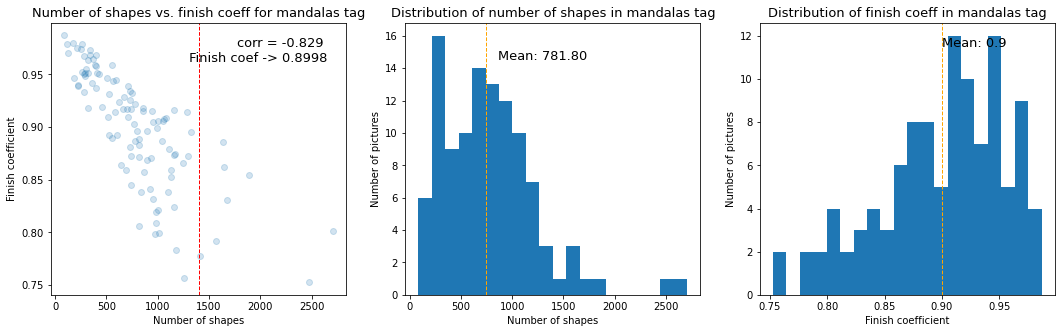

In [276]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

tag='mandalas'

ax1.scatter(correlations[correlations.tags==tag].totalshapesCount, 
            correlations[correlations.tags==tag].finish_coef, alpha=0.2)
    
ax1.set_title('Number of shapes vs. finish coeff for {} tag'.format(tag), size=13)
ax1.set(ylabel='Finish coefficient', xlabel='Number of shapes')
ax1.axvline(1400, color='red', linestyle='dashed', linewidth=1)
ax1.text(correlations[correlations.tags==tag].finish_coef.max()*0.95, 
              0.95, 'corr = {} \n Finish coef -> {}'.format(
                  round(spearman_corr[(spearman_corr.level_1=="totalshapesCount") &
                                     (spearman_corr.tags==tag)].finish_coef.iloc[0], 3),
                  round(correlations[(correlations.tags==tag) & 
                                     (correlations.finish_coef< 1400)].finish_coef.mean(), 4)), 
                horizontalalignment='right', verticalalignment='top', transform=ax1.transAxes,
             size = 13)

ax2.hist(correlations[correlations.tags==tag].totalshapesCount, bins = 20)

ax2.set_title('Distribution of number of shapes in {} tag'.format(tag), size=13)
ax2.set( ylabel='Number of pictures',  xlabel='Number of shapes')
ax2.axvline(round(correlations[correlations.tags==tag].totalshapesCount.median(), 1), 
                   color='orange', linestyle='dashed', linewidth=1)

ymin, ymax = ax2.get_ylim()
ax2.text(round(correlations[correlations.tags==tag].totalshapesCount.mean()*1.1, 1), ymax*0.9,
                'Mean: {:.2f}'.format(round(correlations[correlations.tags==tag].totalshapesCount.mean(), 1)),
                verticalalignment='top', size = 13)

ax3.hist(correlations[correlations.tags==tag].finish_coef, bins = 20)

ax3.set_title('Distribution of finish coeff in {} tag'.format(tag), size=13)
ax3.set(ylabel='Number of pictures',  xlabel='Finish coefficient')
ax3.axvline(round(correlations[correlations.tags==tag].finish_coef.mean(), 1), 
                   color='orange', linestyle='dashed', linewidth=1)

ymin, ymax = ax3.get_ylim()
ax3.text(round(correlations[correlations.tags==tag].finish_coef.mean()*1.001, 1), ymax*0.95, 
                'Mean: {}'.format(round(correlations[correlations.tags==tag].finish_coef.mean(), 3)),
                verticalalignment='top', size = 13)

### Simple

Text(0.9, 11.969999999999999, 'Mean: 0.923')

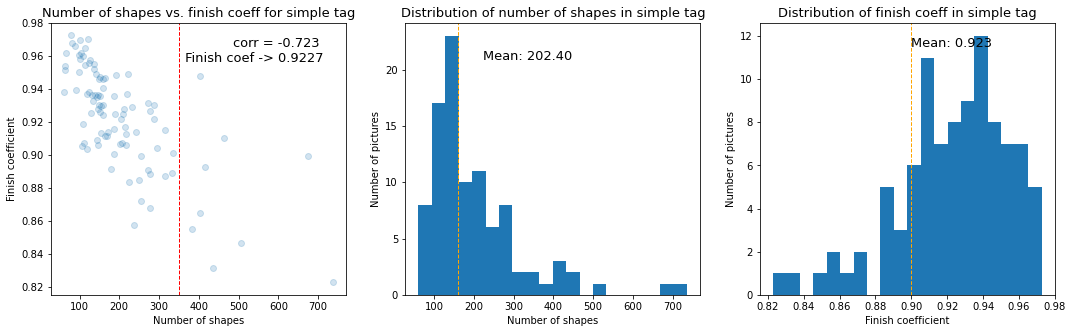

In [289]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

tag='simple'

ax1.scatter(correlations[correlations.tags==tag].totalshapesCount, 
            correlations[correlations.tags==tag].finish_coef, alpha=0.2)
    
ax1.set_title('Number of shapes vs. finish coeff for {} tag'.format(tag), size=13)
ax1.set(ylabel='Finish coefficient', xlabel='Number of shapes')
ax1.axvline(350, color='red', linestyle='dashed', linewidth=1)
ax1.text(correlations[correlations.tags==tag].finish_coef.max()*0.95, 
              0.95, 'corr = {} \n Finish coef -> {}'.format(
                  round(spearman_corr[(spearman_corr.level_1=="totalshapesCount") &
                                     (spearman_corr.tags==tag)].finish_coef.iloc[0], 3),
                  round(correlations[(correlations.tags==tag) & 
                                     (correlations.finish_coef< 350)].finish_coef.mean(), 4)), 
                horizontalalignment='right', verticalalignment='top', transform=ax1.transAxes,
             size = 13)

ax2.hist(correlations[correlations.tags==tag].totalshapesCount, bins = 20)

ax2.set_title('Distribution of number of shapes in {} tag'.format(tag), size=13)
ax2.set( ylabel='Number of pictures',  xlabel='Number of shapes')
ax2.axvline(round(correlations[correlations.tags==tag].totalshapesCount.median(), 1), 
                   color='orange', linestyle='dashed', linewidth=1)

ymin, ymax = ax2.get_ylim()
ax2.text(round(correlations[correlations.tags==tag].totalshapesCount.mean()*1.1, 1), ymax*0.9,
                'Mean: {:.2f}'.format(round(correlations[correlations.tags==tag].totalshapesCount.mean(), 1)),
                verticalalignment='top', size = 13)

ax3.hist(correlations[correlations.tags==tag].finish_coef, bins = 20)

ax3.set_title('Distribution of finish coeff in {} tag'.format(tag), size=13)
ax3.set(ylabel='Number of pictures',  xlabel='Finish coefficient')
ax3.axvline(round(correlations[correlations.tags==tag].finish_coef.mean(), 1), 
                   color='orange', linestyle='dashed', linewidth=1)

ymin, ymax = ax3.get_ylim()
ax3.text(round(correlations[correlations.tags==tag].finish_coef.mean()*1.001, 1), ymax*0.95, 
                'Mean: {}'.format(round(correlations[correlations.tags==tag].finish_coef.mean(), 3)),
                verticalalignment='top', size = 13)

In [270]:
correlations[correlations.tags==tag].finish_coef.mean()

0.9227159247813136

### Daily

Text(0.9, 49.875, 'Mean: 0.899')

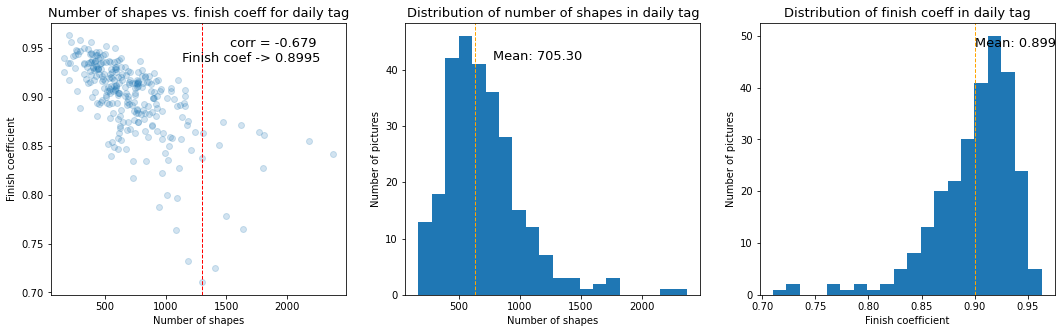

In [290]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

tag='daily'

ax1.scatter(correlations[correlations.tags==tag].totalshapesCount, 
            correlations[correlations.tags==tag].finish_coef, alpha=0.2)
    
ax1.set_title('Number of shapes vs. finish coeff for {} tag'.format(tag), size=13)
ax1.set(ylabel='Finish coefficient', xlabel='Number of shapes')
ax1.axvline(1300, color='red', linestyle='dashed', linewidth=1)
ax1.text(correlations[correlations.tags==tag].finish_coef.max()*0.95, 
              0.95, 'corr = {} \n Finish coef -> {}'.format(
                  round(spearman_corr[(spearman_corr.level_1=="totalshapesCount") &
                                     (spearman_corr.tags==tag)].finish_coef.iloc[0], 3),
                  round(correlations[(correlations.tags==tag) & 
                                     (correlations.finish_coef< 1300)].finish_coef.mean(), 4)), 
                horizontalalignment='right', verticalalignment='top', transform=ax1.transAxes,
             size = 13)

ax2.hist(correlations[correlations.tags==tag].totalshapesCount, bins = 20)

ax2.set_title('Distribution of number of shapes in {} tag'.format(tag), size=13)
ax2.set( ylabel='Number of pictures',  xlabel='Number of shapes')
ax2.axvline(round(correlations[correlations.tags==tag].totalshapesCount.median(), 1), 
                   color='orange', linestyle='dashed', linewidth=1)

ymin, ymax = ax2.get_ylim()
ax2.text(round(correlations[correlations.tags==tag].totalshapesCount.mean()*1.1, 1), ymax*0.9,
                'Mean: {:.2f}'.format(round(correlations[correlations.tags==tag].totalshapesCount.mean(), 1)),
                verticalalignment='top', size = 13)

ax3.hist(correlations[correlations.tags==tag].finish_coef, bins = 20)

ax3.set_title('Distribution of finish coeff in {} tag'.format(tag), size=13)
ax3.set(ylabel='Number of pictures',  xlabel='Finish coefficient')
ax3.axvline(round(correlations[correlations.tags==tag].finish_coef.mean(), 1), 
                   color='orange', linestyle='dashed', linewidth=1)

ymin, ymax = ax3.get_ylim()
ax3.text(round(correlations[correlations.tags==tag].finish_coef.mean()*1.001, 2), ymax*0.95, 
                'Mean: {}'.format(round(correlations[correlations.tags==tag].finish_coef.mean(), 3)),
                verticalalignment='top', size = 13)

### Art

Text(0.85, 9.975, 'Mean: 0.845')

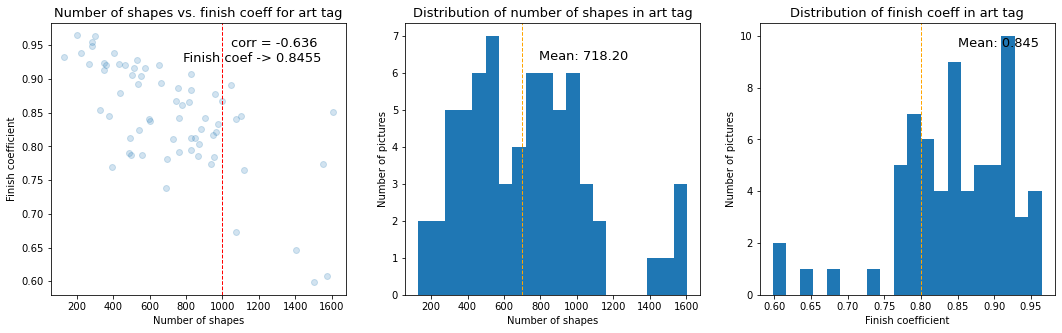

In [291]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

tag='art'

ax1.scatter(correlations[correlations.tags==tag].totalshapesCount, 
            correlations[correlations.tags==tag].finish_coef, alpha=0.2)
    
ax1.set_title('Number of shapes vs. finish coeff for {} tag'.format(tag), size=13)
ax1.set(ylabel='Finish coefficient', xlabel='Number of shapes')
ax1.axvline(1000, color='red', linestyle='dashed', linewidth=1)
ax1.text(correlations[correlations.tags==tag].finish_coef.max()*0.95, 
              0.95, 'corr = {} \n Finish coef -> {}'.format(
                  round(spearman_corr[(spearman_corr.level_1=="totalshapesCount") &
                                     (spearman_corr.tags==tag)].finish_coef.iloc[0], 3),
                  round(correlations[(correlations.tags==tag) & 
                                     (correlations.finish_coef< 1000)].finish_coef.mean(), 4)), 
                horizontalalignment='right', verticalalignment='top', transform=ax1.transAxes,
             size = 13)

ax2.hist(correlations[correlations.tags==tag].totalshapesCount, bins = 20)

ax2.set_title('Distribution of number of shapes in {} tag'.format(tag), size=13)
ax2.set( ylabel='Number of pictures',  xlabel='Number of shapes')
ax2.axvline(round(correlations[correlations.tags==tag].totalshapesCount.median(), 1), 
                   color='orange', linestyle='dashed', linewidth=1)

ymin, ymax = ax2.get_ylim()
ax2.text(round(correlations[correlations.tags==tag].totalshapesCount.mean()*1.1, 1), ymax*0.9,
                'Mean: {:.2f}'.format(round(correlations[correlations.tags==tag].totalshapesCount.mean(), 1)),
                verticalalignment='top', size = 13)

ax3.hist(correlations[correlations.tags==tag].finish_coef, bins = 20)

ax3.set_title('Distribution of finish coeff in {} tag'.format(tag), size=13)
ax3.set(ylabel='Number of pictures',  xlabel='Finish coefficient')
ax3.axvline(round(correlations[correlations.tags==tag].finish_coef.mean(), 1), 
                   color='orange', linestyle='dashed', linewidth=1)

ymin, ymax = ax3.get_ylim()
ax3.text(round(correlations[correlations.tags==tag].finish_coef.mean()*1.001, 2), ymax*0.95, 
                'Mean: {}'.format(round(correlations[correlations.tags==tag].finish_coef.mean(), 3)),
                verticalalignment='top', size = 13)

### Flowers

Text(0.89, 28.9275, 'Mean: 0.885')

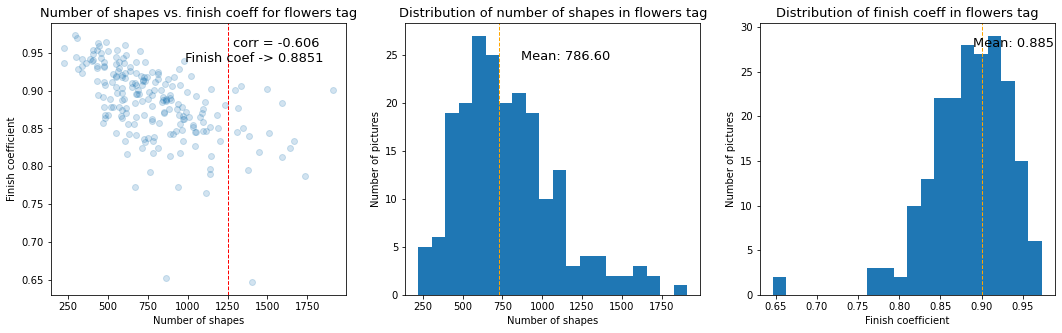

In [292]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

tag='flowers'

ax1.scatter(correlations[correlations.tags==tag].totalshapesCount, 
            correlations[correlations.tags==tag].finish_coef, alpha=0.2)
    
ax1.set_title('Number of shapes vs. finish coeff for {} tag'.format(tag), size=13)
ax1.set(ylabel='Finish coefficient', xlabel='Number of shapes')
ax1.axvline(1250, color='red', linestyle='dashed', linewidth=1)
ax1.text(correlations[correlations.tags==tag].finish_coef.max()*0.95, 
              0.95, 'corr = {} \n Finish coef -> {}'.format(
                  round(spearman_corr[(spearman_corr.level_1=="totalshapesCount") &
                                     (spearman_corr.tags==tag)].finish_coef.iloc[0], 3),
                  round(correlations[(correlations.tags==tag) & 
                                     (correlations.finish_coef< 1250)].finish_coef.mean(), 4)), 
                horizontalalignment='right', verticalalignment='top', transform=ax1.transAxes,
             size = 13)

ax2.hist(correlations[correlations.tags==tag].totalshapesCount, bins = 20)

ax2.set_title('Distribution of number of shapes in {} tag'.format(tag), size=13)
ax2.set( ylabel='Number of pictures',  xlabel='Number of shapes')
ax2.axvline(round(correlations[correlations.tags==tag].totalshapesCount.median(), 1), 
                   color='orange', linestyle='dashed', linewidth=1)

ymin, ymax = ax2.get_ylim()
ax2.text(round(correlations[correlations.tags==tag].totalshapesCount.mean()*1.1, 1), ymax*0.9,
                'Mean: {:.2f}'.format(round(correlations[correlations.tags==tag].totalshapesCount.mean(), 1)),
                verticalalignment='top', size = 13)

ax3.hist(correlations[correlations.tags==tag].finish_coef, bins = 20)

ax3.set_title('Distribution of finish coeff in {} tag'.format(tag), size=13)
ax3.set(ylabel='Number of pictures',  xlabel='Finish coefficient')
ax3.axvline(round(correlations[correlations.tags==tag].finish_coef.mean(), 1), 
                   color='orange', linestyle='dashed', linewidth=1)

ymin, ymax = ax3.get_ylim()
ax3.text(round(correlations[correlations.tags==tag].finish_coef.mean()*1.001, 2), ymax*0.95, 
                'Mean: {}'.format(round(correlations[correlations.tags==tag].finish_coef.mean(), 3)),
                verticalalignment='top', size = 13)

### Travel

Text(0.9, 76.80749999999999, 'Mean: 0.898')

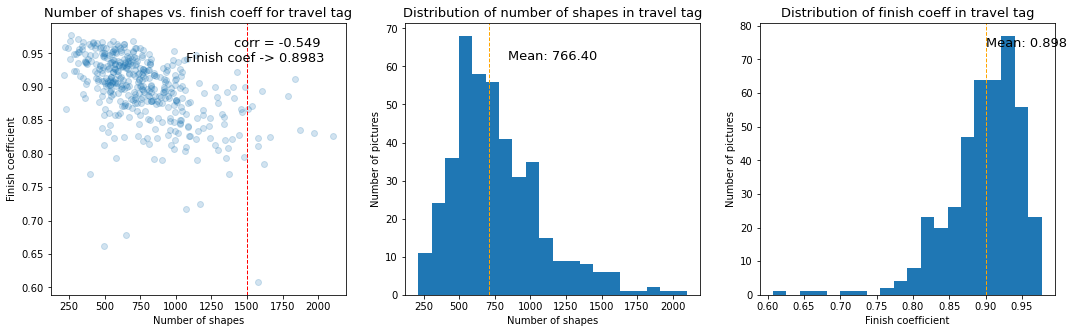

In [293]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

tag='travel'

ax1.scatter(correlations[correlations.tags==tag].totalshapesCount, 
            correlations[correlations.tags==tag].finish_coef, alpha=0.2)
    
ax1.set_title('Number of shapes vs. finish coeff for {} tag'.format(tag), size=13)
ax1.set(ylabel='Finish coefficient', xlabel='Number of shapes')
ax1.axvline(1500, color='red', linestyle='dashed', linewidth=1)
ax1.text(correlations[correlations.tags==tag].finish_coef.max()*0.95, 
              0.95, 'corr = {} \n Finish coef -> {}'.format(
                  round(spearman_corr[(spearman_corr.level_1=="totalshapesCount") &
                                     (spearman_corr.tags==tag)].finish_coef.iloc[0], 3),
                  round(correlations[(correlations.tags==tag) & 
                                     (correlations.finish_coef< 1500)].finish_coef.mean(), 4)), 
                horizontalalignment='right', verticalalignment='top', transform=ax1.transAxes,
             size = 13)

ax2.hist(correlations[correlations.tags==tag].totalshapesCount, bins = 20)

ax2.set_title('Distribution of number of shapes in {} tag'.format(tag), size=13)
ax2.set( ylabel='Number of pictures',  xlabel='Number of shapes')
ax2.axvline(round(correlations[correlations.tags==tag].totalshapesCount.median(), 1), 
                   color='orange', linestyle='dashed', linewidth=1)

ymin, ymax = ax2.get_ylim()
ax2.text(round(correlations[correlations.tags==tag].totalshapesCount.mean()*1.1, 1), ymax*0.9,
                'Mean: {:.2f}'.format(round(correlations[correlations.tags==tag].totalshapesCount.mean(), 1)),
                verticalalignment='top', size = 13)

ax3.hist(correlations[correlations.tags==tag].finish_coef, bins = 20)

ax3.set_title('Distribution of finish coeff in {} tag'.format(tag), size=13)
ax3.set(ylabel='Number of pictures',  xlabel='Finish coefficient')
ax3.axvline(round(correlations[correlations.tags==tag].finish_coef.mean(), 1), 
                   color='orange', linestyle='dashed', linewidth=1)

ymin, ymax = ax3.get_ylim()
ax3.text(round(correlations[correlations.tags==tag].finish_coef.mean()*1.001, 2), ymax*0.95, 
                'Mean: {}'.format(round(correlations[correlations.tags==tag].finish_coef.mean(), 3)),
                verticalalignment='top', size = 13)

### Fashion

Text(0.87, 12.9675, 'Mean: 0.872')

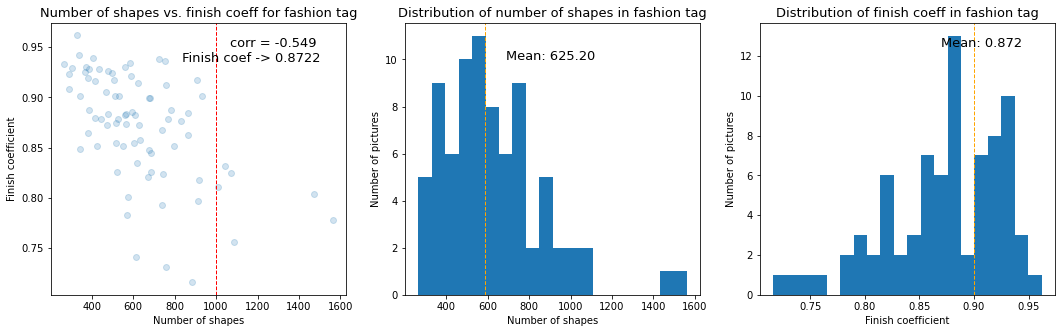

In [281]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

tag='fashion'

ax1.scatter(correlations[correlations.tags==tag].totalshapesCount, 
            correlations[correlations.tags==tag].finish_coef, alpha=0.2)
    
ax1.set_title('Number of shapes vs. finish coeff for {} tag'.format(tag), size=13)
ax1.set(ylabel='Finish coefficient', xlabel='Number of shapes')
ax1.axvline(1000, color='red', linestyle='dashed', linewidth=1)
ax1.text(correlations[correlations.tags==tag].finish_coef.max()*0.95, 
              0.95, 'corr = {} \n Finish coef -> {}'.format(
                  round(spearman_corr[(spearman_corr.level_1=="totalshapesCount") &
                                     (spearman_corr.tags==tag)].finish_coef.iloc[0], 3),
                  round(correlations[(correlations.tags==tag) & 
                                     (correlations.finish_coef< 1000)].finish_coef.mean(), 4)), 
                horizontalalignment='right', verticalalignment='top', transform=ax1.transAxes,
             size = 13)

ax2.hist(correlations[correlations.tags==tag].totalshapesCount, bins = 20)

ax2.set_title('Distribution of number of shapes in {} tag'.format(tag), size=13)
ax2.set( ylabel='Number of pictures',  xlabel='Number of shapes')
ax2.axvline(round(correlations[correlations.tags==tag].totalshapesCount.median(), 1), 
                   color='orange', linestyle='dashed', linewidth=1)

ymin, ymax = ax2.get_ylim()
ax2.text(round(correlations[correlations.tags==tag].totalshapesCount.mean()*1.1, 1), ymax*0.9,
                'Mean: {:.2f}'.format(round(correlations[correlations.tags==tag].totalshapesCount.mean(), 1)),
                verticalalignment='top', size = 13)

ax3.hist(correlations[correlations.tags==tag].finish_coef, bins = 20)

ax3.set_title('Distribution of finish coeff in {} tag'.format(tag), size=13)
ax3.set(ylabel='Number of pictures',  xlabel='Finish coefficient')
ax3.axvline(round(correlations[correlations.tags==tag].finish_coef.mean(), 1), 
                   color='orange', linestyle='dashed', linewidth=1)

ymin, ymax = ax3.get_ylim()
ax3.text(round(correlations[correlations.tags==tag].finish_coef.mean()*1.001, 2), ymax*0.95, 
                'Mean: {}'.format(round(correlations[correlations.tags==tag].finish_coef.mean(), 3)),
                verticalalignment='top', size = 13)

### Buildings

Text(0.89, 34.9125, 'Mean: 0.888')

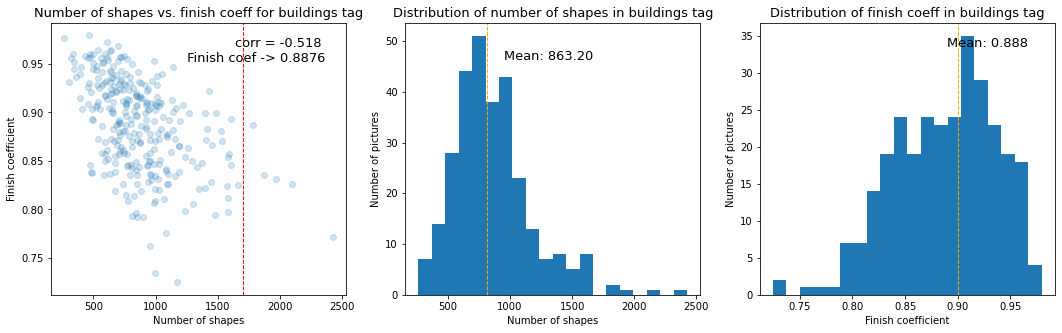

In [282]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

tag='buildings'

ax1.scatter(correlations[correlations.tags==tag].totalshapesCount, 
            correlations[correlations.tags==tag].finish_coef, alpha=0.2)
    
ax1.set_title('Number of shapes vs. finish coeff for {} tag'.format(tag), size=13)
ax1.set(ylabel='Finish coefficient', xlabel='Number of shapes')
ax1.axvline(1700, color='red', linestyle='dashed', linewidth=1)
ax1.text(correlations[correlations.tags==tag].finish_coef.max()*0.95, 
              0.95, 'corr = {} \n Finish coef -> {}'.format(
                  round(spearman_corr[(spearman_corr.level_1=="totalshapesCount") &
                                     (spearman_corr.tags==tag)].finish_coef.iloc[0], 3),
                  round(correlations[(correlations.tags==tag) & 
                                     (correlations.finish_coef< 1700)].finish_coef.mean(), 4)), 
                horizontalalignment='right', verticalalignment='top', transform=ax1.transAxes,
             size = 13)

ax2.hist(correlations[correlations.tags==tag].totalshapesCount, bins = 20)

ax2.set_title('Distribution of number of shapes in {} tag'.format(tag), size=13)
ax2.set( ylabel='Number of pictures',  xlabel='Number of shapes')
ax2.axvline(round(correlations[correlations.tags==tag].totalshapesCount.median(), 1), 
                   color='orange', linestyle='dashed', linewidth=1)

ymin, ymax = ax2.get_ylim()
ax2.text(round(correlations[correlations.tags==tag].totalshapesCount.mean()*1.1, 1), ymax*0.9,
                'Mean: {:.2f}'.format(round(correlations[correlations.tags==tag].totalshapesCount.mean(), 1)),
                verticalalignment='top', size = 13)

ax3.hist(correlations[correlations.tags==tag].finish_coef, bins = 20)

ax3.set_title('Distribution of finish coeff in {} tag'.format(tag), size=13)
ax3.set(ylabel='Number of pictures',  xlabel='Finish coefficient')
ax3.axvline(round(correlations[correlations.tags==tag].finish_coef.mean(), 1), 
                   color='orange', linestyle='dashed', linewidth=1)

ymin, ymax = ax3.get_ylim()
ax3.text(round(correlations[correlations.tags==tag].finish_coef.mean()*1.001, 2), ymax*0.95, 
                'Mean: {}'.format(round(correlations[correlations.tags==tag].finish_coef.mean(), 3)),
                verticalalignment='top', size = 13)

### Nature

Text(0.9, 40.897499999999994, 'Mean: 0.903')

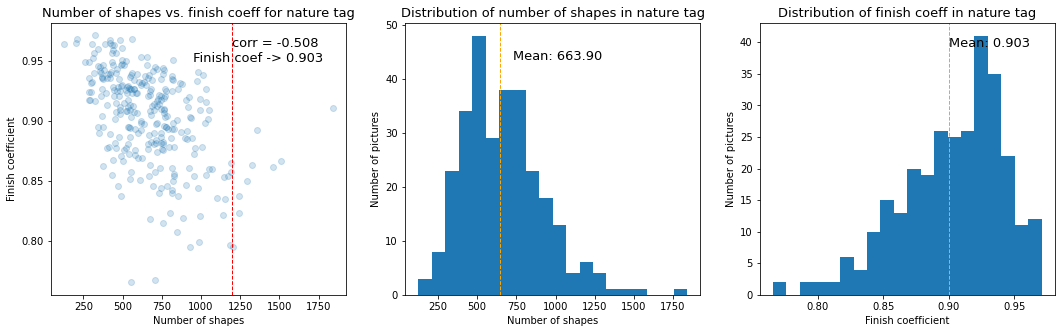

In [283]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

tag='nature'

ax1.scatter(correlations[correlations.tags==tag].totalshapesCount, 
            correlations[correlations.tags==tag].finish_coef, alpha=0.2)
    
ax1.set_title('Number of shapes vs. finish coeff for {} tag'.format(tag), size=13)
ax1.set(ylabel='Finish coefficient', xlabel='Number of shapes')
ax1.axvline(1200, color='red', linestyle='dashed', linewidth=1)
ax1.text(correlations[correlations.tags==tag].finish_coef.max()*0.95, 
              0.95, 'corr = {} \n Finish coef -> {}'.format(
                  round(spearman_corr[(spearman_corr.level_1=="totalshapesCount") &
                                     (spearman_corr.tags==tag)].finish_coef.iloc[0], 3),
                  round(correlations[(correlations.tags==tag) & 
                                     (correlations.finish_coef< 1200)].finish_coef.mean(), 4)), 
                horizontalalignment='right', verticalalignment='top', transform=ax1.transAxes,
             size = 13)

ax2.hist(correlations[correlations.tags==tag].totalshapesCount, bins = 20)

ax2.set_title('Distribution of number of shapes in {} tag'.format(tag), size=13)
ax2.set( ylabel='Number of pictures',  xlabel='Number of shapes')
ax2.axvline(round(correlations[correlations.tags==tag].totalshapesCount.median(), 1), 
                   color='orange', linestyle='dashed', linewidth=1)

ymin, ymax = ax2.get_ylim()
ax2.text(round(correlations[correlations.tags==tag].totalshapesCount.mean()*1.1, 1), ymax*0.9,
                'Mean: {:.2f}'.format(round(correlations[correlations.tags==tag].totalshapesCount.mean(), 1)),
                verticalalignment='top', size = 13)

ax3.hist(correlations[correlations.tags==tag].finish_coef, bins = 20)

ax3.set_title('Distribution of finish coeff in {} tag'.format(tag), size=13)
ax3.set(ylabel='Number of pictures',  xlabel='Finish coefficient')
ax3.axvline(round(correlations[correlations.tags==tag].finish_coef.mean(), 1), 
                   color='orange', linestyle='dashed', linewidth=1)

ymin, ymax = ax3.get_ylim()
ax3.text(round(correlations[correlations.tags==tag].finish_coef.mean()*1.001, 2), ymax*0.95, 
                'Mean: {}'.format(round(correlations[correlations.tags==tag].finish_coef.mean(), 3)),
                verticalalignment='top', size = 13)

### Butterflies

Text(0.88, 18.952499999999997, 'Mean: 0.879')

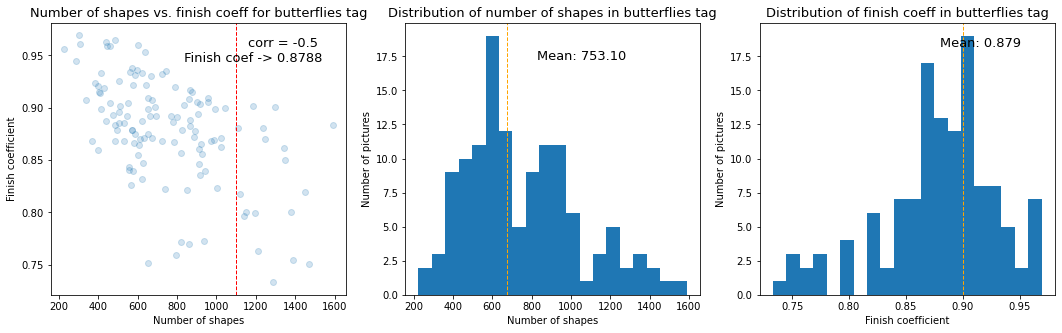

In [284]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

tag='butterflies'

ax1.scatter(correlations[correlations.tags==tag].totalshapesCount, 
            correlations[correlations.tags==tag].finish_coef, alpha=0.2)
    
ax1.set_title('Number of shapes vs. finish coeff for {} tag'.format(tag), size=13)
ax1.set(ylabel='Finish coefficient', xlabel='Number of shapes')
ax1.axvline(1100, color='red', linestyle='dashed', linewidth=1)
ax1.text(correlations[correlations.tags==tag].finish_coef.max()*0.95, 
              0.95, 'corr = {} \n Finish coef -> {}'.format(
                  round(spearman_corr[(spearman_corr.level_1=="totalshapesCount") &
                                     (spearman_corr.tags==tag)].finish_coef.iloc[0], 3),
                  round(correlations[(correlations.tags==tag) & 
                                     (correlations.finish_coef< 1100)].finish_coef.mean(), 4)), 
                horizontalalignment='right', verticalalignment='top', transform=ax1.transAxes,
             size = 13)

ax2.hist(correlations[correlations.tags==tag].totalshapesCount, bins = 20)

ax2.set_title('Distribution of number of shapes in {} tag'.format(tag), size=13)
ax2.set( ylabel='Number of pictures',  xlabel='Number of shapes')
ax2.axvline(round(correlations[correlations.tags==tag].totalshapesCount.median(), 1), 
                   color='orange', linestyle='dashed', linewidth=1)

ymin, ymax = ax2.get_ylim()
ax2.text(round(correlations[correlations.tags==tag].totalshapesCount.mean()*1.1, 1), ymax*0.9,
                'Mean: {:.2f}'.format(round(correlations[correlations.tags==tag].totalshapesCount.mean(), 1)),
                verticalalignment='top', size = 13)

ax3.hist(correlations[correlations.tags==tag].finish_coef, bins = 20)

ax3.set_title('Distribution of finish coeff in {} tag'.format(tag), size=13)
ax3.set(ylabel='Number of pictures',  xlabel='Finish coefficient')
ax3.axvline(round(correlations[correlations.tags==tag].finish_coef.mean(), 1), 
                   color='orange', linestyle='dashed', linewidth=1)

ymin, ymax = ax3.get_ylim()
ax3.text(round(correlations[correlations.tags==tag].finish_coef.mean()*1.001, 2), ymax*0.95, 
                'Mean: {}'.format(round(correlations[correlations.tags==tag].finish_coef.mean(), 3)),
                verticalalignment='top', size = 13)

### Food

Text(0.89, 22.9425, 'Mean: 0.90')

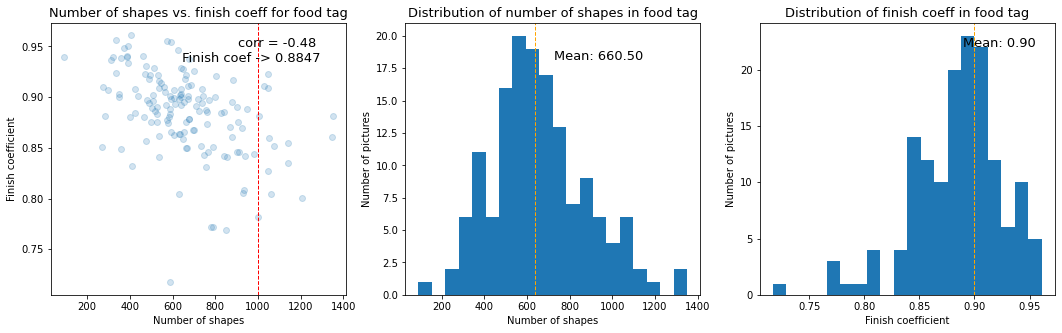

In [241]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

tag='food'

ax1.scatter(correlations[correlations.tags==tag].totalshapesCount, 
            correlations[correlations.tags==tag].finish_coef, alpha=0.2)
    
ax1.set_title('Number of shapes vs. finish coeff for {} tag'.format(tag), size=13)
ax1.set(ylabel='Finish coefficient', xlabel='Number of shapes')
ax1.axvline(1000, color='red', linestyle='dashed', linewidth=1)
ax1.text(correlations[correlations.tags==tag].finish_coef.max()*0.95, 
              0.95, 'corr = {} \n Finish coef -> {}'.format(
                  round(spearman_corr[(spearman_corr.level_1=="totalshapesCount") &
                                     (spearman_corr.tags==tag)].finish_coef.iloc[0], 3),
                  round(correlations[(correlations.tags==tag) & 
                                     (correlations.finish_coef< 1000)].finish_coef.mean(), 4)), 
                horizontalalignment='right', verticalalignment='top', transform=ax1.transAxes,
             size = 13)

ax2.hist(correlations[correlations.tags==tag].totalshapesCount, bins = 20)

ax2.set_title('Distribution of number of shapes in {} tag'.format(tag), size=13)
ax2.set( ylabel='Number of pictures',  xlabel='Number of shapes')
ax2.axvline(round(correlations[correlations.tags==tag].totalshapesCount.median(), 1), 
                   color='orange', linestyle='dashed', linewidth=1)

ymin, ymax = ax2.get_ylim()
ax2.text(round(correlations[correlations.tags==tag].totalshapesCount.mean()*1.1, 1), ymax*0.9,
                'Mean: {:.2f}'.format(round(correlations[correlations.tags==tag].totalshapesCount.mean(), 1)),
                verticalalignment='top', size = 13)

ax3.hist(correlations[correlations.tags==tag].finish_coef, bins = 20)

ax3.set_title('Distribution of finish coeff in {} tag'.format(tag), size=13)
ax3.set(ylabel='Number of pictures',  xlabel='Finish coefficient')
ax3.axvline(round(correlations[correlations.tags==tag].finish_coef.mean(), 1), 
                   color='orange', linestyle='dashed', linewidth=1)

ymin, ymax = ax3.get_ylim()
ax3.text(round(correlations[correlations.tags==tag].finish_coef.mean()*1.001, 2), ymax*0.95, 
                'Mean: {}'.format(round(correlations[correlations.tags==tag].finish_coef.mean(), 3)),
                verticalalignment='top', size = 13)

### Birds

Text(0.89, 42.8925, 'Mean: 0.90')

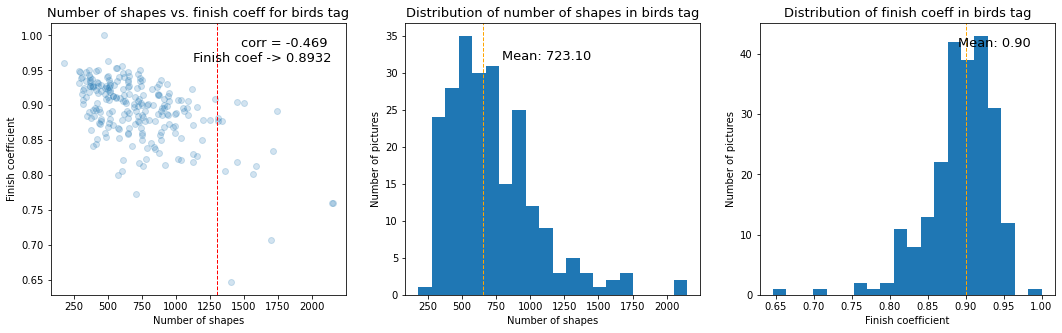

In [244]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

tag='birds'

ax1.scatter(correlations[correlations.tags==tag].totalshapesCount, 
            correlations[correlations.tags==tag].finish_coef, alpha=0.2)
    
ax1.set_title('Number of shapes vs. finish coeff for {} tag'.format(tag), size=13)
ax1.set(ylabel='Finish coefficient', xlabel='Number of shapes')
ax1.axvline(1300, color='red', linestyle='dashed', linewidth=1)
ax1.text(correlations[correlations.tags==tag].finish_coef.max()*0.95, 
              0.95, 'corr = {} \n Finish coef -> {}'.format(
                  round(spearman_corr[(spearman_corr.level_1=="totalshapesCount") &
                                     (spearman_corr.tags==tag)].finish_coef.iloc[0], 3),
                  round(correlations[(correlations.tags==tag) & 
                                     (correlations.finish_coef< 1300)].finish_coef.mean(), 4)), 
                horizontalalignment='right', verticalalignment='top', transform=ax1.transAxes,
             size = 13)

ax2.hist(correlations[correlations.tags==tag].totalshapesCount, bins = 20)

ax2.set_title('Distribution of number of shapes in {} tag'.format(tag), size=13)
ax2.set( ylabel='Number of pictures',  xlabel='Number of shapes')
ax2.axvline(round(correlations[correlations.tags==tag].totalshapesCount.median(), 1), 
                   color='orange', linestyle='dashed', linewidth=1)

ymin, ymax = ax2.get_ylim()
ax2.text(round(correlations[correlations.tags==tag].totalshapesCount.mean()*1.1, 1), ymax*0.9,
                'Mean: {:.2f}'.format(round(correlations[correlations.tags==tag].totalshapesCount.mean(), 1)),
                verticalalignment='top', size = 13)

ax3.hist(correlations[correlations.tags==tag].finish_coef, bins = 20)

ax3.set_title('Distribution of finish coeff in {} tag'.format(tag), size=13)
ax3.set(ylabel='Number of pictures',  xlabel='Finish coefficient')
ax3.axvline(round(correlations[correlations.tags==tag].finish_coef.mean(), 1), 
                   color='orange', linestyle='dashed', linewidth=1)

ymin, ymax = ax3.get_ylim()
ax3.text(round(correlations[correlations.tags==tag].finish_coef.mean()*1.001, 2), ymax*0.95, 
                'Mean: {:.2f}'.format(round(correlations[correlations.tags==tag].finish_coef.mean(), 1)),
                verticalalignment='top', size = 13)

### Fantasy

Text(0.87, 47.879999999999995, 'Mean: 0.90')

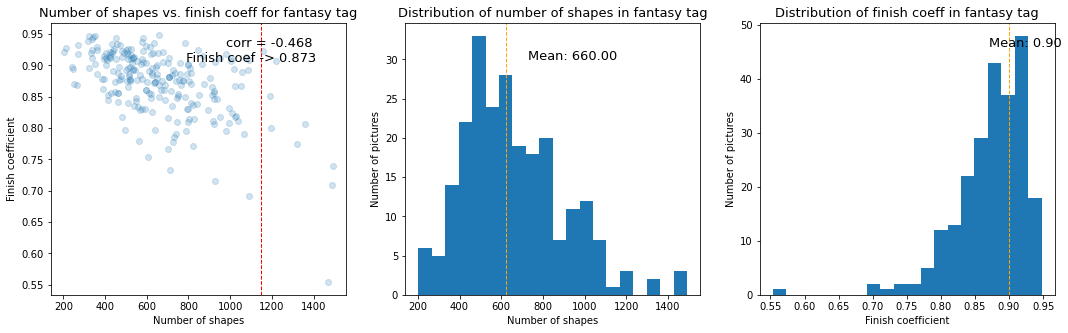

In [246]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

tag='fantasy'

ax1.scatter(correlations[correlations.tags==tag].totalshapesCount, 
            correlations[correlations.tags==tag].finish_coef, alpha=0.2)
    
ax1.set_title('Number of shapes vs. finish coeff for {} tag'.format(tag), size=13)
ax1.set(ylabel='Finish coefficient', xlabel='Number of shapes')
ax1.axvline(1150, color='red', linestyle='dashed', linewidth=1)
ax1.text(correlations[correlations.tags==tag].finish_coef.max()*0.95, 
              0.95, 'corr = {} \n Finish coef -> {}'.format(
                  round(spearman_corr[(spearman_corr.level_1=="totalshapesCount") &
                                     (spearman_corr.tags==tag)].finish_coef.iloc[0], 3),
                  round(correlations[(correlations.tags==tag) & 
                                     (correlations.finish_coef< 1150)].finish_coef.mean(), 4)), 
                horizontalalignment='right', verticalalignment='top', transform=ax1.transAxes,
             size = 13)

ax2.hist(correlations[correlations.tags==tag].totalshapesCount, bins = 20)

ax2.set_title('Distribution of number of shapes in {} tag'.format(tag), size=13)
ax2.set( ylabel='Number of pictures',  xlabel='Number of shapes')
ax2.axvline(round(correlations[correlations.tags==tag].totalshapesCount.median(), 1), 
                   color='orange', linestyle='dashed', linewidth=1)

ymin, ymax = ax2.get_ylim()
ax2.text(round(correlations[correlations.tags==tag].totalshapesCount.mean()*1.1, 1), ymax*0.9,
                'Mean: {:.2f}'.format(round(correlations[correlations.tags==tag].totalshapesCount.mean(), 1)),
                verticalalignment='top', size = 13)

ax3.hist(correlations[correlations.tags==tag].finish_coef, bins = 20)

ax3.set_title('Distribution of finish coeff in {} tag'.format(tag), size=13)
ax3.set(ylabel='Number of pictures',  xlabel='Finish coefficient')
ax3.axvline(round(correlations[correlations.tags==tag].finish_coef.mean(), 1), 
                   color='orange', linestyle='dashed', linewidth=1)

ymin, ymax = ax3.get_ylim()
ax3.text(round(correlations[correlations.tags==tag].finish_coef.mean()*1.001, 2), ymax*0.95, 
                'Mean: {:.2f}'.format(round(correlations[correlations.tags==tag].finish_coef.mean(), 1)),
                verticalalignment='top', size = 13)

### Holidays

Text(0.86, 14.962499999999999, 'Mean: 0.90')

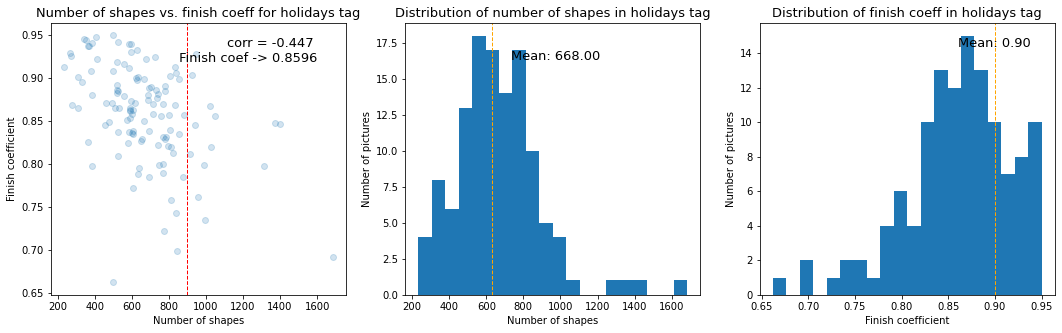

In [248]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

tag='holidays'

ax1.scatter(correlations[correlations.tags==tag].totalshapesCount, 
            correlations[correlations.tags==tag].finish_coef, alpha=0.2)
    
ax1.set_title('Number of shapes vs. finish coeff for {} tag'.format(tag), size=13)
ax1.set(ylabel='Finish coefficient', xlabel='Number of shapes')
ax1.axvline(900, color='red', linestyle='dashed', linewidth=1)
ax1.text(correlations[correlations.tags==tag].finish_coef.max()*0.95, 
              0.95, 'corr = {} \n Finish coef -> {}'.format(
                  round(spearman_corr[(spearman_corr.level_1=="totalshapesCount") &
                                     (spearman_corr.tags==tag)].finish_coef.iloc[0], 3),
                  round(correlations[(correlations.tags==tag) & 
                                     (correlations.finish_coef< 900)].finish_coef.mean(), 4)), 
                horizontalalignment='right', verticalalignment='top', transform=ax1.transAxes,
             size = 13)

ax2.hist(correlations[correlations.tags==tag].totalshapesCount, bins = 20)

ax2.set_title('Distribution of number of shapes in {} tag'.format(tag), size=13)
ax2.set( ylabel='Number of pictures',  xlabel='Number of shapes')
ax2.axvline(round(correlations[correlations.tags==tag].totalshapesCount.median(), 1), 
                   color='orange', linestyle='dashed', linewidth=1)

ymin, ymax = ax2.get_ylim()
ax2.text(round(correlations[correlations.tags==tag].totalshapesCount.mean()*1.1, 1), ymax*0.9,
                'Mean: {:.2f}'.format(round(correlations[correlations.tags==tag].totalshapesCount.mean(), 1)),
                verticalalignment='top', size = 13)

ax3.hist(correlations[correlations.tags==tag].finish_coef, bins = 20)

ax3.set_title('Distribution of finish coeff in {} tag'.format(tag), size=13)
ax3.set(ylabel='Number of pictures',  xlabel='Finish coefficient')
ax3.axvline(round(correlations[correlations.tags==tag].finish_coef.mean(), 1), 
                   color='orange', linestyle='dashed', linewidth=1)

ymin, ymax = ax3.get_ylim()
ax3.text(round(correlations[correlations.tags==tag].finish_coef.mean()*1.001, 2), ymax*0.95, 
                'Mean: {:.2f}'.format(round(correlations[correlations.tags==tag].finish_coef.mean(), 1)),
                verticalalignment='top', size = 13)

### Animals

C:\Users\a.nosko\Anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\a.nosko\Anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Text(0.89, 66.8325, 'Mean: 0.90')

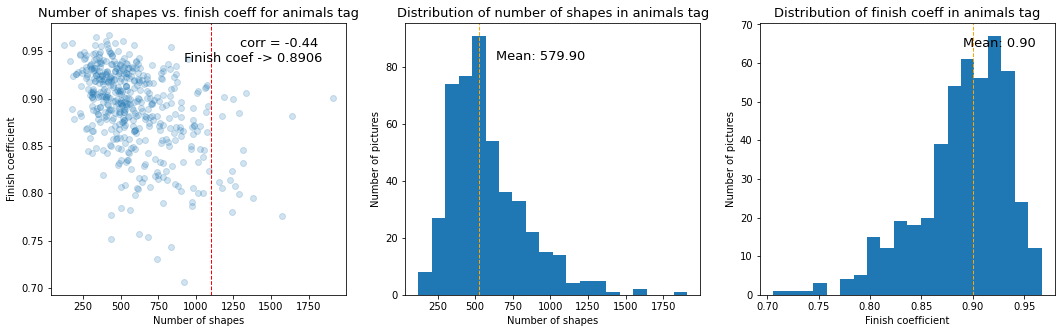

In [249]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

tag='animals'

ax1.scatter(correlations[correlations.tags==tag].totalshapesCount, 
            correlations[correlations.tags==tag].finish_coef, alpha=0.2)
    
ax1.set_title('Number of shapes vs. finish coeff for {} tag'.format(tag), size=13)
ax1.set(ylabel='Finish coefficient', xlabel='Number of shapes')
ax1.axvline(1100, color='red', linestyle='dashed', linewidth=1)
ax1.text(correlations[correlations.tags==tag].finish_coef.max()*0.95, 
              0.95, 'corr = {} \n Finish coef -> {}'.format(
                  round(spearman_corr[(spearman_corr.level_1=="totalshapesCount") &
                                     (spearman_corr.tags==tag)].finish_coef.iloc[0], 3),
                  round(correlations[(correlations.tags==tag) & 
                                     (correlations.finish_coef< 1100)].finish_coef.mean(), 4)), 
                horizontalalignment='right', verticalalignment='top', transform=ax1.transAxes,
             size = 13)

ax2.hist(correlations[correlations.tags==tag].totalshapesCount, bins = 20)

ax2.set_title('Distribution of number of shapes in {} tag'.format(tag), size=13)
ax2.set( ylabel='Number of pictures',  xlabel='Number of shapes')
ax2.axvline(round(correlations[correlations.tags==tag].totalshapesCount.median(), 1), 
                   color='orange', linestyle='dashed', linewidth=1)

ymin, ymax = ax2.get_ylim()
ax2.text(round(correlations[correlations.tags==tag].totalshapesCount.mean()*1.1, 1), ymax*0.9,
                'Mean: {:.2f}'.format(round(correlations[correlations.tags==tag].totalshapesCount.mean(), 1)),
                verticalalignment='top', size = 13)

ax3.hist(correlations[correlations.tags==tag].finish_coef, bins = 20)

ax3.set_title('Distribution of finish coeff in {} tag'.format(tag), size=13)
ax3.set(ylabel='Number of pictures',  xlabel='Finish coefficient')
ax3.axvline(round(correlations[correlations.tags==tag].finish_coef.mean(), 1), 
                   color='orange', linestyle='dashed', linewidth=1)

ymin, ymax = ax3.get_ylim()
ax3.text(round(correlations[correlations.tags==tag].finish_coef.mean()*1.001, 2), ymax*0.95, 
                'Mean: {:.2f}'.format(round(correlations[correlations.tags==tag].finish_coef.mean(), 1)),
                verticalalignment='top', size = 13)

### People

Text(0.88, 87.78, 'Mean: 0.90')

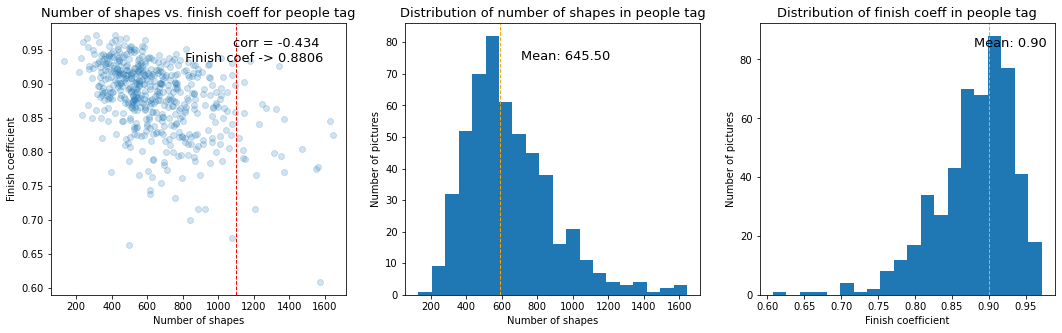

In [252]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

tag='people'

ax1.scatter(correlations[correlations.tags==tag].totalshapesCount, 
            correlations[correlations.tags==tag].finish_coef, alpha=0.2)
    
ax1.set_title('Number of shapes vs. finish coeff for {} tag'.format(tag), size=13)
ax1.set(ylabel='Finish coefficient', xlabel='Number of shapes')
ax1.axvline(1100, color='red', linestyle='dashed', linewidth=1)
ax1.text(correlations[correlations.tags==tag].finish_coef.max()*0.95, 
              0.95, 'corr = {} \n Finish coef -> {}'.format(
                  round(spearman_corr[(spearman_corr.level_1=="totalshapesCount") &
                                     (spearman_corr.tags==tag)].finish_coef.iloc[0], 3),
                  round(correlations[(correlations.tags==tag) & 
                                     (correlations.finish_coef< 1100)].finish_coef.mean(), 4)), 
                horizontalalignment='right', verticalalignment='top', transform=ax1.transAxes,
             size = 13)

ax2.hist(correlations[correlations.tags==tag].totalshapesCount, bins = 20)

ax2.set_title('Distribution of number of shapes in {} tag'.format(tag), size=13)
ax2.set( ylabel='Number of pictures',  xlabel='Number of shapes')
ax2.axvline(round(correlations[correlations.tags==tag].totalshapesCount.median(), 1), 
                   color='orange', linestyle='dashed', linewidth=1)

ymin, ymax = ax2.get_ylim()
ax2.text(round(correlations[correlations.tags==tag].totalshapesCount.mean()*1.1, 1), ymax*0.9,
                'Mean: {:.2f}'.format(round(correlations[correlations.tags==tag].totalshapesCount.mean(), 1)),
                verticalalignment='top', size = 13)

ax3.hist(correlations[correlations.tags==tag].finish_coef, bins = 20)

ax3.set_title('Distribution of finish coeff in {} tag'.format(tag), size=13)
ax3.set(ylabel='Number of pictures',  xlabel='Finish coefficient')
ax3.axvline(round(correlations[correlations.tags==tag].finish_coef.mean(), 1), 
                   color='orange', linestyle='dashed', linewidth=1)

ymin, ymax = ax3.get_ylim()
ax3.text(round(correlations[correlations.tags==tag].finish_coef.mean()*1.001, 2), ymax*0.95, 
                'Mean: {:.2f}'.format(round(correlations[correlations.tags==tag].finish_coef.mean(), 1)),
                verticalalignment='top', size = 13)

### Other

Text(0.88, 43.89, 'Mean: 0.90')

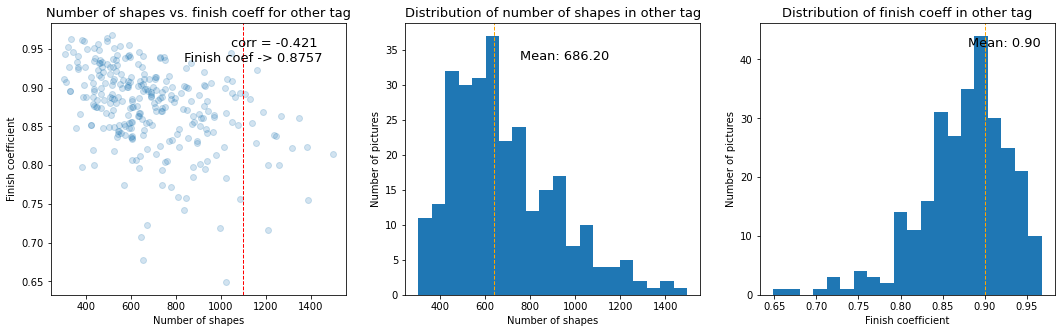

In [253]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

tag='other'

ax1.scatter(correlations[correlations.tags==tag].totalshapesCount, 
            correlations[correlations.tags==tag].finish_coef, alpha=0.2)
    
ax1.set_title('Number of shapes vs. finish coeff for {} tag'.format(tag), size=13)
ax1.set(ylabel='Finish coefficient', xlabel='Number of shapes')
ax1.axvline(1100, color='red', linestyle='dashed', linewidth=1)
ax1.text(correlations[correlations.tags==tag].finish_coef.max()*0.95, 
              0.95, 'corr = {} \n Finish coef -> {}'.format(
                  round(spearman_corr[(spearman_corr.level_1=="totalshapesCount") &
                                     (spearman_corr.tags==tag)].finish_coef.iloc[0], 3),
                  round(correlations[(correlations.tags==tag) & 
                                     (correlations.finish_coef< 1100)].finish_coef.mean(), 4)), 
                horizontalalignment='right', verticalalignment='top', transform=ax1.transAxes,
             size = 13)

ax2.hist(correlations[correlations.tags==tag].totalshapesCount, bins = 20)

ax2.set_title('Distribution of number of shapes in {} tag'.format(tag), size=13)
ax2.set( ylabel='Number of pictures',  xlabel='Number of shapes')
ax2.axvline(round(correlations[correlations.tags==tag].totalshapesCount.median(), 1), 
                   color='orange', linestyle='dashed', linewidth=1)

ymin, ymax = ax2.get_ylim()
ax2.text(round(correlations[correlations.tags==tag].totalshapesCount.mean()*1.1, 1), ymax*0.9,
                'Mean: {:.2f}'.format(round(correlations[correlations.tags==tag].totalshapesCount.mean(), 1)),
                verticalalignment='top', size = 13)

ax3.hist(correlations[correlations.tags==tag].finish_coef, bins = 20)

ax3.set_title('Distribution of finish coeff in {} tag'.format(tag), size=13)
ax3.set(ylabel='Number of pictures',  xlabel='Finish coefficient')
ax3.axvline(round(correlations[correlations.tags==tag].finish_coef.mean(), 1), 
                   color='orange', linestyle='dashed', linewidth=1)

ymin, ymax = ax3.get_ylim()
ax3.text(round(correlations[correlations.tags==tag].finish_coef.mean()*1.001, 2), ymax*0.95, 
                'Mean: {:.2f}'.format(round(correlations[correlations.tags==tag].finish_coef.mean(), 1)),
                verticalalignment='top', size = 13)

### Editors' choice

Text(0.88, 14.962499999999999, 'Mean: 0.90')

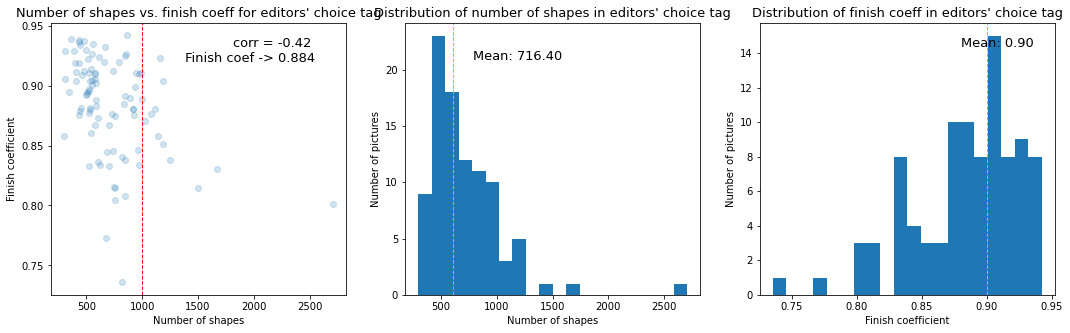

In [255]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

tag="editors' choice"

ax1.scatter(correlations[correlations.tags==tag].totalshapesCount, 
            correlations[correlations.tags==tag].finish_coef, alpha=0.2)
    
ax1.set_title('Number of shapes vs. finish coeff for {} tag'.format(tag), size=13)
ax1.set(ylabel='Finish coefficient', xlabel='Number of shapes')
ax1.axvline(1000, color='red', linestyle='dashed', linewidth=1)
ax1.text(correlations[correlations.tags==tag].finish_coef.max()*0.95, 
              0.95, 'corr = {} \n Finish coef -> {}'.format(
                  round(spearman_corr[(spearman_corr.level_1=="totalshapesCount") &
                                     (spearman_corr.tags==tag)].finish_coef.iloc[0], 3),
                  round(correlations[(correlations.tags==tag) & 
                                     (correlations.finish_coef< 1000)].finish_coef.mean(), 4)), 
                horizontalalignment='right', verticalalignment='top', transform=ax1.transAxes,
             size = 13)

ax2.hist(correlations[correlations.tags==tag].totalshapesCount, bins = 20)

ax2.set_title('Distribution of number of shapes in {} tag'.format(tag), size=13)
ax2.set( ylabel='Number of pictures',  xlabel='Number of shapes')
ax2.axvline(round(correlations[correlations.tags==tag].totalshapesCount.median(), 1), 
                   color='orange', linestyle='dashed', linewidth=1)

ymin, ymax = ax2.get_ylim()
ax2.text(round(correlations[correlations.tags==tag].totalshapesCount.mean()*1.1, 1), ymax*0.9,
                'Mean: {:.2f}'.format(round(correlations[correlations.tags==tag].totalshapesCount.mean(), 1)),
                verticalalignment='top', size = 13)

ax3.hist(correlations[correlations.tags==tag].finish_coef, bins = 20)

ax3.set_title('Distribution of finish coeff in {} tag'.format(tag), size=13)
ax3.set(ylabel='Number of pictures',  xlabel='Finish coefficient')
ax3.axvline(round(correlations[correlations.tags==tag].finish_coef.mean(), 1), 
                   color='orange', linestyle='dashed', linewidth=1)

ymin, ymax = ax3.get_ylim()
ax3.text(round(correlations[correlations.tags==tag].finish_coef.mean()*1.001, 2), ymax*0.95, 
                'Mean: {:.2f}'.format(round(correlations[correlations.tags==tag].finish_coef.mean(), 1)),
                verticalalignment='top', size = 13)

### Interior

Text(0.88, 21.945, 'Mean: 0.90')

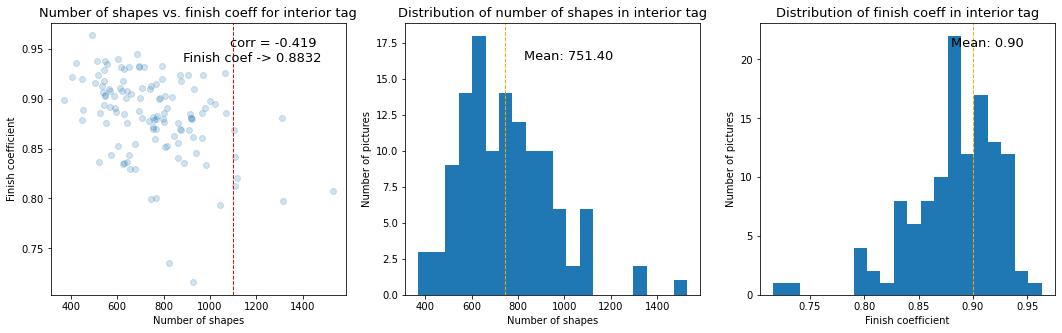

In [256]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

tag='interior'

ax1.scatter(correlations[correlations.tags==tag].totalshapesCount, 
            correlations[correlations.tags==tag].finish_coef, alpha=0.2)
    
ax1.set_title('Number of shapes vs. finish coeff for {} tag'.format(tag), size=13)
ax1.set(ylabel='Finish coefficient', xlabel='Number of shapes')
ax1.axvline(1100, color='red', linestyle='dashed', linewidth=1)
ax1.text(correlations[correlations.tags==tag].finish_coef.max()*0.95, 
              0.95, 'corr = {} \n Finish coef -> {}'.format(
                  round(spearman_corr[(spearman_corr.level_1=="totalshapesCount") &
                                     (spearman_corr.tags==tag)].finish_coef.iloc[0], 3),
                  round(correlations[(correlations.tags==tag) & 
                                     (correlations.finish_coef< 1100)].finish_coef.mean(), 4)), 
                horizontalalignment='right', verticalalignment='top', transform=ax1.transAxes,
             size = 13)

ax2.hist(correlations[correlations.tags==tag].totalshapesCount, bins = 20)

ax2.set_title('Distribution of number of shapes in {} tag'.format(tag), size=13)
ax2.set( ylabel='Number of pictures',  xlabel='Number of shapes')
ax2.axvline(round(correlations[correlations.tags==tag].totalshapesCount.median(), 1), 
                   color='orange', linestyle='dashed', linewidth=1)

ymin, ymax = ax2.get_ylim()
ax2.text(round(correlations[correlations.tags==tag].totalshapesCount.mean()*1.1, 1), ymax*0.9,
                'Mean: {:.2f}'.format(round(correlations[correlations.tags==tag].totalshapesCount.mean(), 1)),
                verticalalignment='top', size = 13)

ax3.hist(correlations[correlations.tags==tag].finish_coef, bins = 20)

ax3.set_title('Distribution of finish coeff in {} tag'.format(tag), size=13)
ax3.set(ylabel='Number of pictures',  xlabel='Finish coefficient')
ax3.axvline(round(correlations[correlations.tags==tag].finish_coef.mean(), 1), 
                   color='orange', linestyle='dashed', linewidth=1)

ymin, ymax = ax3.get_ylim()
ax3.text(round(correlations[correlations.tags==tag].finish_coef.mean()*1.001, 2), ymax*0.95, 
                'Mean: {:.2f}'.format(round(correlations[correlations.tags==tag].finish_coef.mean(), 1)),
                verticalalignment='top', size = 13)

### Horoscopes

Text(0.89, 3.9899999999999998, 'Mean: 0.90')

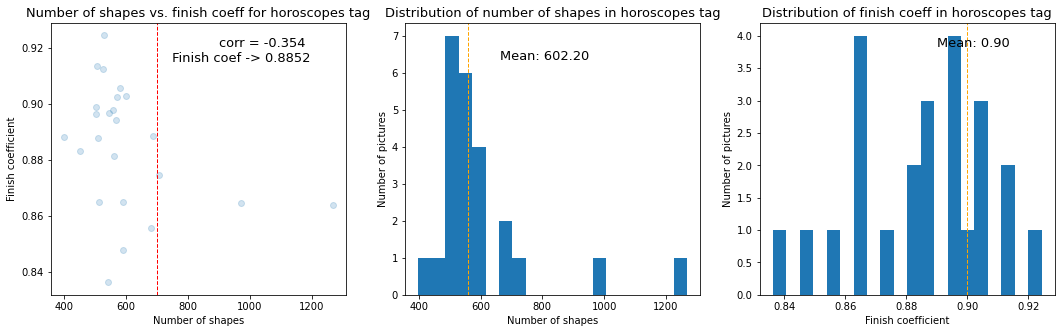

In [258]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

tag='horoscopes'

ax1.scatter(correlations[correlations.tags==tag].totalshapesCount, 
            correlations[correlations.tags==tag].finish_coef, alpha=0.2)
    
ax1.set_title('Number of shapes vs. finish coeff for {} tag'.format(tag), size=13)
ax1.set(ylabel='Finish coefficient', xlabel='Number of shapes')
ax1.axvline(700, color='red', linestyle='dashed', linewidth=1)
ax1.text(correlations[correlations.tags==tag].finish_coef.max()*0.95, 
              0.95, 'corr = {} \n Finish coef -> {}'.format(
                  round(spearman_corr[(spearman_corr.level_1=="totalshapesCount") &
                                     (spearman_corr.tags==tag)].finish_coef.iloc[0], 3),
                  round(correlations[(correlations.tags==tag) & 
                                     (correlations.finish_coef< 700)].finish_coef.mean(), 4)), 
                horizontalalignment='right', verticalalignment='top', transform=ax1.transAxes,
             size = 13)

ax2.hist(correlations[correlations.tags==tag].totalshapesCount, bins = 20)

ax2.set_title('Distribution of number of shapes in {} tag'.format(tag), size=13)
ax2.set( ylabel='Number of pictures',  xlabel='Number of shapes')
ax2.axvline(round(correlations[correlations.tags==tag].totalshapesCount.median(), 1), 
                   color='orange', linestyle='dashed', linewidth=1)

ymin, ymax = ax2.get_ylim()
ax2.text(round(correlations[correlations.tags==tag].totalshapesCount.mean()*1.1, 1), ymax*0.9,
                'Mean: {:.2f}'.format(round(correlations[correlations.tags==tag].totalshapesCount.mean(), 1)),
                verticalalignment='top', size = 13)

ax3.hist(correlations[correlations.tags==tag].finish_coef, bins = 20)

ax3.set_title('Distribution of finish coeff in {} tag'.format(tag), size=13)
ax3.set(ylabel='Number of pictures',  xlabel='Finish coefficient')
ax3.axvline(round(correlations[correlations.tags==tag].finish_coef.mean(), 1), 
                   color='orange', linestyle='dashed', linewidth=1)

ymin, ymax = ax3.get_ylim()
ax3.text(round(correlations[correlations.tags==tag].finish_coef.mean()*1.001, 2), ymax*0.95, 
                'Mean: {:.2f}'.format(round(correlations[correlations.tags==tag].finish_coef.mean(), 1)),
                verticalalignment='top', size = 13)

### Blend

Text(0.8, 7.9799999999999995, 'Mean: 0.80')

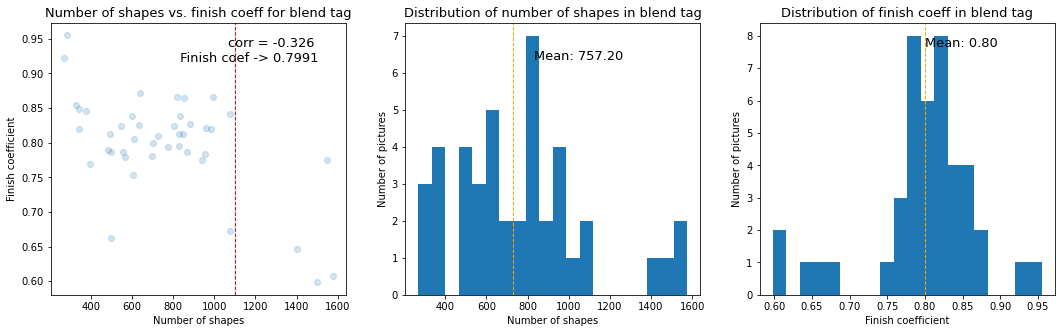

In [260]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

tag='blend'

ax1.scatter(correlations[correlations.tags==tag].totalshapesCount, 
            correlations[correlations.tags==tag].finish_coef, alpha=0.2)
    
ax1.set_title('Number of shapes vs. finish coeff for {} tag'.format(tag), size=13)
ax1.set(ylabel='Finish coefficient', xlabel='Number of shapes')
ax1.axvline(1100, color='red', linestyle='dashed', linewidth=1)
ax1.text(correlations[correlations.tags==tag].finish_coef.max()*0.95, 
              0.95, 'corr = {} \n Finish coef -> {}'.format(
                  round(spearman_corr[(spearman_corr.level_1=="totalshapesCount") &
                                     (spearman_corr.tags==tag)].finish_coef.iloc[0], 3),
                  round(correlations[(correlations.tags==tag) & 
                                     (correlations.finish_coef< 1100)].finish_coef.mean(), 4)), 
                horizontalalignment='right', verticalalignment='top', transform=ax1.transAxes,
             size = 13)

ax2.hist(correlations[correlations.tags==tag].totalshapesCount, bins = 20)

ax2.set_title('Distribution of number of shapes in {} tag'.format(tag), size=13)
ax2.set( ylabel='Number of pictures',  xlabel='Number of shapes')
ax2.axvline(round(correlations[correlations.tags==tag].totalshapesCount.median(), 1), 
                   color='orange', linestyle='dashed', linewidth=1)

ymin, ymax = ax2.get_ylim()
ax2.text(round(correlations[correlations.tags==tag].totalshapesCount.mean()*1.1, 1), ymax*0.9,
                'Mean: {:.2f}'.format(round(correlations[correlations.tags==tag].totalshapesCount.mean(), 1)),
                verticalalignment='top', size = 13)

ax3.hist(correlations[correlations.tags==tag].finish_coef, bins = 20)

ax3.set_title('Distribution of finish coeff in {} tag'.format(tag), size=13)
ax3.set(ylabel='Number of pictures',  xlabel='Finish coefficient')
ax3.axvline(round(correlations[correlations.tags==tag].finish_coef.mean(), 1), 
                   color='orange', linestyle='dashed', linewidth=1)

ymin, ymax = ax3.get_ylim()
ax3.text(round(correlations[correlations.tags==tag].finish_coef.mean()*1.001, 2), ymax*0.95, 
                'Mean: {:.2f}'.format(round(correlations[correlations.tags==tag].finish_coef.mean(), 1)),
                verticalalignment='top', size = 13)

### Sea

Text(0.89, 15.959999999999999, 'Mean: 0.90')

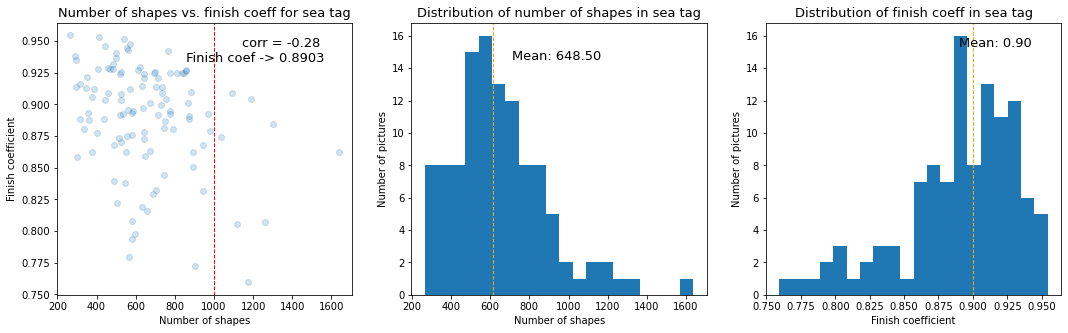

In [262]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

tag='sea'

ax1.scatter(correlations[correlations.tags==tag].totalshapesCount, 
            correlations[correlations.tags==tag].finish_coef, alpha=0.2)
    
ax1.set_title('Number of shapes vs. finish coeff for {} tag'.format(tag), size=13)
ax1.set(ylabel='Finish coefficient', xlabel='Number of shapes')
ax1.axvline(1000, color='red', linestyle='dashed', linewidth=1)
ax1.text(correlations[correlations.tags==tag].finish_coef.max()*0.95, 
              0.95, 'corr = {} \n Finish coef -> {}'.format(
                  round(spearman_corr[(spearman_corr.level_1=="totalshapesCount") &
                                     (spearman_corr.tags==tag)].finish_coef.iloc[0], 3),
                  round(correlations[(correlations.tags==tag) & 
                                     (correlations.finish_coef< 1000)].finish_coef.mean(), 4)), 
                horizontalalignment='right', verticalalignment='top', transform=ax1.transAxes,
             size = 13)

ax2.hist(correlations[correlations.tags==tag].totalshapesCount, bins = 20)

ax2.set_title('Distribution of number of shapes in {} tag'.format(tag), size=13)
ax2.set( ylabel='Number of pictures',  xlabel='Number of shapes')
ax2.axvline(round(correlations[correlations.tags==tag].totalshapesCount.median(), 1), 
                   color='orange', linestyle='dashed', linewidth=1)

ymin, ymax = ax2.get_ylim()
ax2.text(round(correlations[correlations.tags==tag].totalshapesCount.mean()*1.1, 1), ymax*0.9,
                'Mean: {:.2f}'.format(round(correlations[correlations.tags==tag].totalshapesCount.mean(), 1)),
                verticalalignment='top', size = 13)

ax3.hist(correlations[correlations.tags==tag].finish_coef, bins = 20)

ax3.set_title('Distribution of finish coeff in {} tag'.format(tag), size=13)
ax3.set(ylabel='Number of pictures',  xlabel='Finish coefficient')
ax3.axvline(round(correlations[correlations.tags==tag].finish_coef.mean(), 1), 
                   color='orange', linestyle='dashed', linewidth=1)

ymin, ymax = ax3.get_ylim()
ax3.text(round(correlations[correlations.tags==tag].finish_coef.mean()*1.001, 2), ymax*0.95, 
                'Mean: {:.2f}'.format(round(correlations[correlations.tags==tag].finish_coef.mean(), 1)),
                verticalalignment='top', size = 13)

### Vehicles

Text(0.89, 22.9425, 'Mean: 0.90')

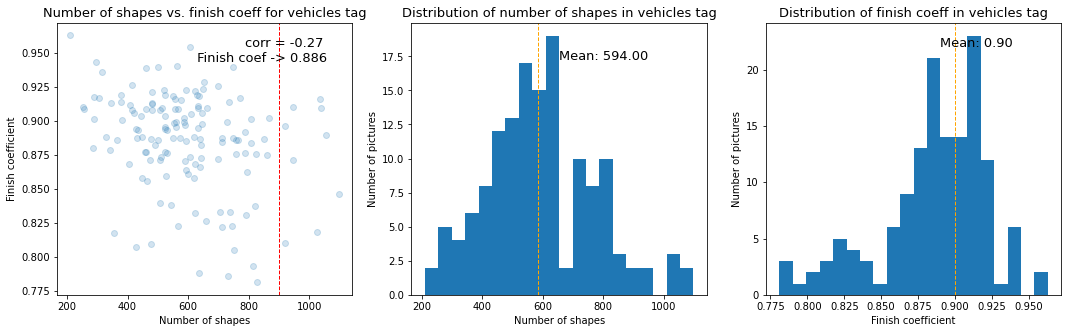

In [264]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

tag='vehicles'

ax1.scatter(correlations[correlations.tags==tag].totalshapesCount, 
            correlations[correlations.tags==tag].finish_coef, alpha=0.2)
    
ax1.set_title('Number of shapes vs. finish coeff for {} tag'.format(tag), size=13)
ax1.set(ylabel='Finish coefficient', xlabel='Number of shapes')
ax1.axvline(900, color='red', linestyle='dashed', linewidth=1)
ax1.text(correlations[correlations.tags==tag].finish_coef.max()*0.95, 
              0.95, 'corr = {} \n Finish coef -> {}'.format(
                  round(spearman_corr[(spearman_corr.level_1=="totalshapesCount") &
                                     (spearman_corr.tags==tag)].finish_coef.iloc[0], 3),
                  round(correlations[(correlations.tags==tag) & 
                                     (correlations.finish_coef< 900)].finish_coef.mean(), 4)), 
                horizontalalignment='right', verticalalignment='top', transform=ax1.transAxes,
             size = 13)

ax2.hist(correlations[correlations.tags==tag].totalshapesCount, bins = 20)

ax2.set_title('Distribution of number of shapes in {} tag'.format(tag), size=13)
ax2.set( ylabel='Number of pictures',  xlabel='Number of shapes')
ax2.axvline(round(correlations[correlations.tags==tag].totalshapesCount.median(), 1), 
                   color='orange', linestyle='dashed', linewidth=1)

ymin, ymax = ax2.get_ylim()
ax2.text(round(correlations[correlations.tags==tag].totalshapesCount.mean()*1.1, 1), ymax*0.9,
                'Mean: {:.2f}'.format(round(correlations[correlations.tags==tag].totalshapesCount.mean(), 1)),
                verticalalignment='top', size = 13)

ax3.hist(correlations[correlations.tags==tag].finish_coef, bins = 20)

ax3.set_title('Distribution of finish coeff in {} tag'.format(tag), size=13)
ax3.set(ylabel='Number of pictures',  xlabel='Finish coefficient')
ax3.axvline(round(correlations[correlations.tags==tag].finish_coef.mean(), 1), 
                   color='orange', linestyle='dashed', linewidth=1)

ymin, ymax = ax3.get_ylim()
ax3.text(round(correlations[correlations.tags==tag].finish_coef.mean()*1.001, 2), ymax*0.95, 
                'Mean: {:.2f}'.format(round(correlations[correlations.tags==tag].finish_coef.mean(), 1)),
                verticalalignment='top', size = 13)

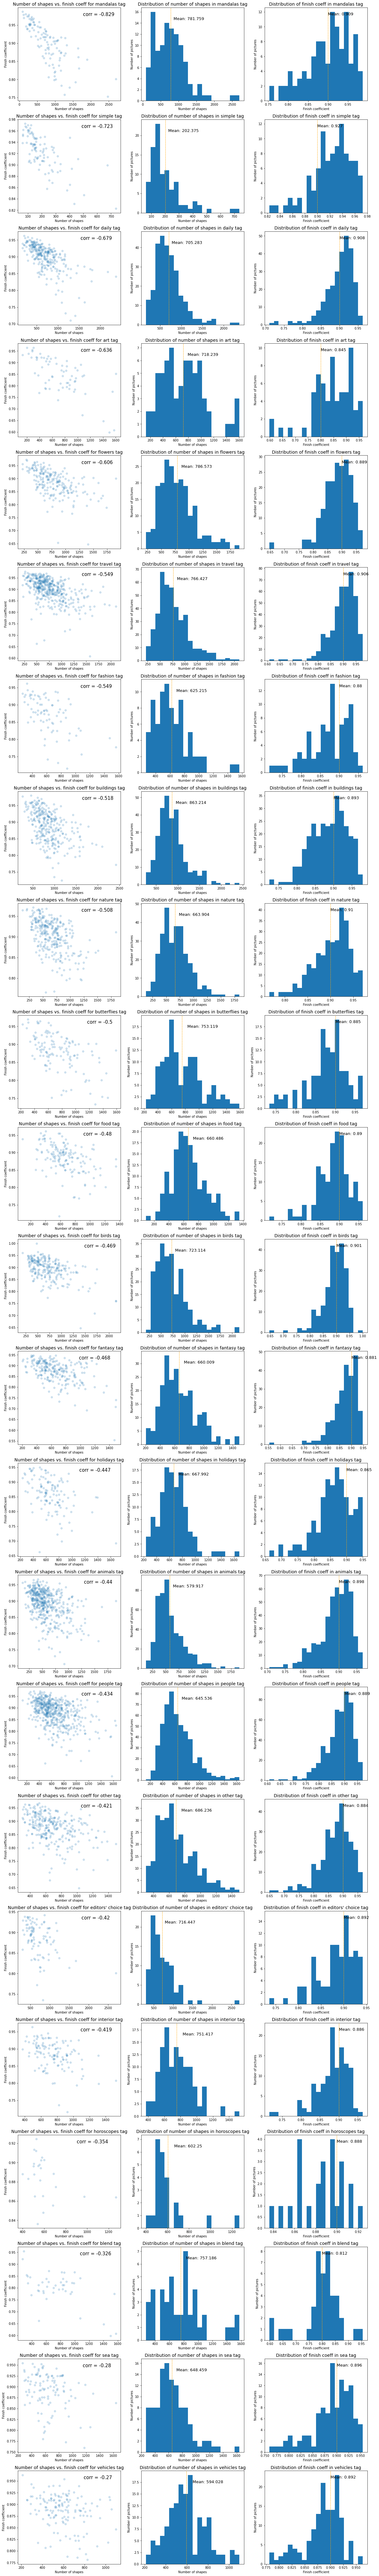

In [288]:
# fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 4))
fig, ax = plt.subplots(23, 3, figsize=(20, 150))

tags = ["mandalas",
"simple",
"daily",
"art",
"flowers",
"travel",
"fashion",
"buildings",
"nature",
"butterflies",
"food",
"birds",
"fantasy",
"holidays",
"animals",
"people",
"other",
"editors' choice",
"interior",
"horoscopes",
"blend",
"sea",
"vehicles"]



for i, tag in enumerate(tags):
    
    ax[i, 0].scatter(correlations[correlations.tags==tag].totalshapesCount, 
            correlations[correlations.tags==tag].finish_coef, alpha=0.2)
    
    ax[i, 0].set_title('Number of shapes vs. finish coeff for {} tag'.format(tag), size=14)
    ax[i, 0].set(ylabel='Finish coefficient', xlabel='Number of shapes')
    ax[i, 0].text(correlations[correlations.tags==tag].finish_coef.max()*0.95, 
                  0.95, 'corr = {}'.format(round(spearman_corr[(spearman_corr.level_1=="totalshapesCount") &
                                                               (spearman_corr.tags==tag)].finish_coef.iloc[0], 3)), 
                    horizontalalignment='right', verticalalignment='top', transform=ax[i, 0].transAxes,
                 size = 15)

    ax[i, 1].hist(correlations[correlations.tags==tag].totalshapesCount, bins = 20)
    
    ax[i, 1].set_title('Distribution of number of shapes in {} tag'.format(tag), size=14)
    ax[i, 1].set( ylabel='Number of pictures',  xlabel='Number of shapes')
    ax[i, 1].axvline(round(correlations[correlations.tags==tag].totalshapesCount.mean(), 1), 
                       color='orange', linestyle='dashed', linewidth=1)

    ymin, ymax = ax[i, 1].get_ylim()
    ax[i, 1].text(round(correlations[correlations.tags==tag].totalshapesCount.mean()*1.1, 1), ymax*0.9,
                    'Mean: {}'.format(round(correlations[correlations.tags==tag].totalshapesCount.mean(), 3)),
                    verticalalignment='top', size = 13)

    ax[i, 2].hist(correlations[correlations.tags==tag].finish_coef, bins = 20)
    
    ax[i, 2].set_title('Distribution of finish coeff in {} tag'.format(tag), size=14)
    ax[i, 2].set(ylabel='Number of pictures',  xlabel='Finish coefficient')
    ax[i, 2].axvline(round(correlations[correlations.tags==tag].finish_coef.mean(), 1), 
                       color='orange', linestyle='dashed', linewidth=1)

    ymin, ymax = ax[i, 2].get_ylim()
    ax[i, 2].text(round(correlations[correlations.tags==tag].finish_coef.mean()*1.001, 1), ymax*0.95, 
                    'Mean: {}'.format(round(correlations[correlations.tags==tag].finish_coef.median(), 3)),
                    verticalalignment='top', size = 13)
    
# fig.tight_layout(h_pad=20)

In [116]:
correlations.tags.unique()

array(['animals', 'fantasy', 'people', 'mandalas', 'travel', 'food',
       'simple', 'flowers', 'other', 'nature', 'birds', 'vehicles', 'sea',
       'butterflies', 'interior', 'buildings', 'blend', 'fashion', 'art',
       'holidays', 'horoscopes', "editors' choice", 'daily', nan],
      dtype=object)

In [172]:
23*3

69